# Lecture 10: Time Series Analysis
## F&W ECOL 458: Environmental Data Science

**Duration:** 75 minutes

**Learning Objectives:**
- Work with datetime objects in pandas
- Index and slice time series data by date
- Resample data to different time frequencies
- Apply rolling windows for smoothing
- Decompose time series into trend, seasonality, and residuals
- Understand autocorrelation and stationarity
- Apply simple forecasting methods

---

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

---
## 1. Introduction to Time Series

A **time series** is a sequence of data points collected over time. Environmental examples include:

- Daily temperature or precipitation
- Hourly air quality measurements
- Monthly streamflow
- Annual tree ring widths
- Satellite observations over years

**Key characteristics of time series:**
- **Trend:** Long-term increase or decrease
- **Seasonality:** Regular, repeating patterns (daily, annual, etc.)
- **Noise:** Random variation

In [2]:
# Create sample environmental time series data
np.random.seed(42)

# 5 years of daily temperature data
dates = pd.date_range('2020-01-01', '2024-12-31', freq='D')
n_days = len(dates)
day_of_year = dates.dayofyear

# Components:
# 1. Seasonal pattern (annual cycle)
seasonal = 15 * np.sin(2 * np.pi * (day_of_year - 80) / 365)

# 2. Slight warming trend over 5 years
trend = np.linspace(0, 2, n_days)

# 3. Random noise
noise = np.random.normal(0, 4, n_days)

# Combine into temperature series (baseline of 10°C)
temperature = 10 + seasonal + trend + noise

# Create DataFrame
weather = pd.DataFrame({
    'date': dates,
    'temperature_c': temperature,
    'precipitation_mm': np.random.exponential(3, n_days)
})

print(f"Dataset: {len(weather)} days from {weather['date'].min().date()} to {weather['date'].max().date()}")
weather.head()

Dataset: 1827 days from 2020-01-01 to 2024-12-31


,date,temperature_c,precipitation_mm
0,2020-01-01,-2.680869,2.701701
1,2020-01-02,-5.163469,0.030549
2,2020-01-03,-1.958014,3.032596
3,2020-01-04,1.609306,7.335453
4,2020-01-05,-5.349179,2.844687


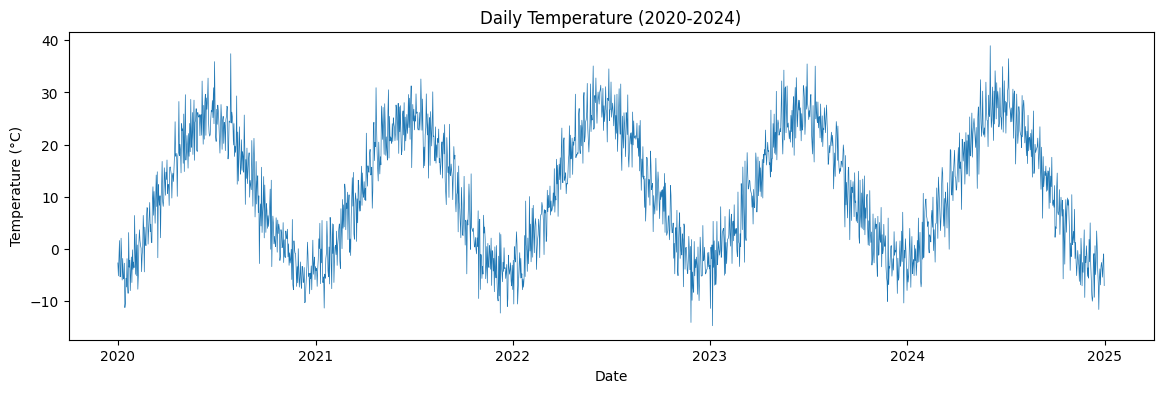

In [3]:
# Quick visualization
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(weather['date'], weather['temperature_c'], linewidth=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Daily Temperature (2020-2024)')
plt.show()

---
## 2. Working with DateTime in Pandas (10 min)

### 2.1 DateTime Data Types

In [4]:
# Check the data type of the date column
print(f"Date column type: {weather['date'].dtype}")

Date column type: datetime64[ns]


In [5]:
# If dates are strings, convert with pd.to_datetime()
date_strings = ['2024-01-15', '2024-02-20', '2024-03-25']
print(f"Original type: {type(date_strings[0])}")

date_converted = pd.to_datetime(date_strings)
print(f"Converted type: {date_converted.dtype}")
print(date_converted)

Original type: <class 'str'>
Converted type: datetime64[ns]
DatetimeIndex(['2024-01-15', '2024-02-20', '2024-03-25'], dtype='datetime64[ns]', freq=None)


In [6]:
# pd.to_datetime() handles many formats
print(pd.to_datetime('2024-01-15'))        # ISO format
print(pd.to_datetime('01/15/2024'))        # US format
print(pd.to_datetime('15-Jan-2024'))       # With month name
print(pd.to_datetime('January 15, 2024'))  # Full month name

2024-01-15 00:00:00
2024-01-15 00:00:00
2024-01-15 00:00:00
2024-01-15 00:00:00


### 2.2 Extracting Date Components

Use the `.dt` accessor to extract parts of a datetime.

In [7]:
# Extract various components
weather['year'] = weather['date'].dt.year
weather['month'] = weather['date'].dt.month
weather['day'] = weather['date'].dt.day
weather['day_of_year'] = weather['date'].dt.dayofyear
weather['day_of_week'] = weather['date'].dt.dayofweek  # 0=Monday, 6=Sunday
weather['week'] = weather['date'].dt.isocalendar().week
weather['quarter'] = weather['date'].dt.quarter

weather[['date', 'year', 'month', 'day', 'day_of_year', 'day_of_week', 'quarter']].head(10)

,date,year,month,day,day_of_year,day_of_week,quarter
0,2020-01-01,2020,1,1,1,2,1
1,2020-01-02,2020,1,2,2,3,1
2,2020-01-03,2020,1,3,3,4,1
3,2020-01-04,2020,1,4,4,5,1
4,2020-01-05,2020,1,5,5,6,1
5,2020-01-06,2020,1,6,6,0,1
6,2020-01-07,2020,1,7,7,1,1
7,2020-01-08,2020,1,8,8,2,1
8,2020-01-09,2020,1,9,9,3,1
9,2020-01-10,2020,1,10,10,4,1


In [8]:
# Get month names
weather['month_name'] = weather['date'].dt.month_name()
weather[['date', 'month', 'month_name']].drop_duplicates('month').head(12)

,date,month,month_name
0,2020-01-01,1,January
31,2020-02-01,2,February
60,2020-03-01,3,March
91,2020-04-01,4,April
121,2020-05-01,5,May
152,2020-06-01,6,June
182,2020-07-01,7,July
213,2020-08-01,8,August
244,2020-09-01,9,September
274,2020-10-01,10,October


### 2.3 Setting DateTime as Index

Setting the date as the index enables powerful time series operations.

In [9]:
# Set date as the index
weather_ts = weather.set_index('date')
weather_ts.head()

,temperature_c,precipitation_mm,year,month,day,day_of_year,day_of_week,week,quarter,month_name
date,,,,,,,,,,
2020-01-01,-2.680869,2.701701,2020,1,1,1,2,1,1,January
2020-01-02,-5.163469,0.030549,2020,1,2,2,3,1,1,January
2020-01-03,-1.958014,3.032596,2020,1,3,3,4,1,1,January
2020-01-04,1.609306,7.335453,2020,1,4,4,5,1,1,January
2020-01-05,-5.349179,2.844687,2020,1,5,5,6,1,1,January


In [10]:
# Check the index type
print(f"Index type: {type(weather_ts.index)}")
print(f"Index dtype: {weather_ts.index.dtype}")

Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index dtype: datetime64[ns]


---
## 3. Indexing and Slicing by Date

With a DatetimeIndex, you can select data using date strings.

### 3.1 Selecting Specific Dates

In [11]:
# Select a specific date
weather_ts.loc['2023-07-04']

,2023-07-04
temperature_c,26.517908
precipitation_mm,4.719243
year,2023
month,7
day,4
day_of_year,185
day_of_week,1
week,27
quarter,3
month_name,July


In [12]:
# Select a specific month (partial string indexing)
july_2023 = weather_ts.loc['2023-07']
print(f"July 2023: {len(july_2023)} days")
july_2023.head()

July 2023: 31 days


,temperature_c,precipitation_mm,year,month,day,day_of_year,day_of_week,week,quarter,month_name
date,,,,,,,,,,
2023-07-01,27.715855,0.916509,2023,7,1,182,5,26,3,July
2023-07-02,26.862183,0.001961,2023,7,2,183,6,26,3,July
2023-07-03,24.804569,6.136142,2023,7,3,184,0,27,3,July
2023-07-04,26.517908,4.719243,2023,7,4,185,1,27,3,July
2023-07-05,25.312254,2.961177,2023,7,5,186,2,27,3,July


In [13]:
# Select an entire year
year_2022 = weather_ts.loc['2022']
print(f"Year 2022: {len(year_2022)} days")
year_2022.head()

Year 2022: 365 days


,temperature_c,precipitation_mm,year,month,day,day_of_year,day_of_week,week,quarter,month_name
date,,,,,,,,,,
2022-01-01,-7.780559,8.686915,2022,1,1,1,5,52,1,January
2022-01-02,-2.176743,4.001507,2022,1,2,2,6,52,1,January
2022-01-03,-10.558445,6.436586,2022,1,3,3,0,1,1,January
2022-01-04,0.434467,0.679319,2022,1,4,4,1,1,1,January
2022-01-05,-1.721518,2.657182,2022,1,5,5,2,1,1,January


### 3.2 Selecting Date Ranges

In [14]:
# Select a date range using slice
summer_2023 = weather_ts.loc['2023-06-01':'2023-08-31']
print(f"Summer 2023: {len(summer_2023)} days")
print(f"Mean temperature: {summer_2023['temperature_c'].mean():.1f}°C")

Summer 2023: 92 days
Mean temperature: 23.6°C


In [15]:
# Select from a date to the end
recent = weather_ts.loc['2024-10-01':]
print(f"From Oct 2024 to end: {len(recent)} days")

From Oct 2024 to end: 92 days


In [16]:
# Select up to a date
early = weather_ts.loc[:'2020-03-31']
print(f"Up to March 2020: {len(early)} days")

Up to March 2020: 91 days


### 3.3 Filtering with Boolean Conditions

In [17]:
# Filter using index properties
# Get all July data across all years
all_julys = weather_ts[weather_ts.index.month == 7]
print(f"All July days: {len(all_julys)}")
print(f"Mean July temperature: {all_julys['temperature_c'].mean():.1f}°C")

All July days: 155
Mean July temperature: 24.6°C


In [18]:
# Get all weekends
weekends = weather_ts[weather_ts.index.dayofweek >= 5]
print(f"Weekend days: {len(weekends)}")

Weekend days: 522


---
## 4. Resampling

**Resampling** changes the frequency of your time series:
- **Downsampling:** Higher to lower frequency (daily → monthly)
- **Upsampling:** Lower to higher frequency (monthly → daily)

### 4.1 Common Frequency Codes

| Code | Frequency |
|------|----------|
| `D` | Daily |
| `W` | Weekly |
| `M` | Month end |
| `MS` | Month start |
| `Q` | Quarter end |
| `Y` | Year end |
| `H` | Hourly |

In [19]:
# Resample daily data to monthly means
monthly = weather_ts['temperature_c'].resample('M').mean()

print(f"Original: {len(weather_ts)} daily observations")
print(f"Resampled: {len(monthly)} monthly observations")
monthly.head(12)

Original: 1827 daily observations
Resampled: 60 monthly observations


/tmp/ipython-input-3864009084.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = weather_ts['temperature_c'].resample('M').mean()


,temperature_c
date,
2020-01-31,-4.011211
2020-02-29,1.430068
2020-03-31,9.124703
2020-04-30,16.661753
2020-05-31,22.076639
2020-06-30,25.990211
2020-07-31,24.121709
2020-08-31,18.234200
2020-09-30,10.570510


In [20]:
# Different aggregation functions
monthly_stats = weather_ts['temperature_c'].resample('M').agg(['mean', 'min', 'max', 'std'])
monthly_stats.head(12)

/tmp/ipython-input-1251820647.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_stats = weather_ts['temperature_c'].resample('M').agg(['mean', 'min', 'max', 'std'])


,mean,min,max,std
date,,,,
2020-01-31,-4.011211,-11.244089,3.137245,3.373099
2020-02-29,1.430068,-7.722674,8.903959,4.420155
2020-03-31,9.124703,-1.687401,16.775685,4.576300
2020-04-30,16.661753,8.329365,28.263266,4.661672
2020-05-31,22.076639,14.833108,29.573583,4.232944
2020-06-30,25.990211,20.075567,35.906897,3.913499
2020-07-31,24.121709,17.251644,37.424589,3.851943
2020-08-31,18.234200,8.532923,29.326943,4.394796
2020-09-30,10.570510,-2.807208,21.206743,5.436608


In [21]:
# For precipitation, sum is more appropriate than mean
monthly_precip = weather_ts['precipitation_mm'].resample('M').sum()
monthly_precip.head(12)

/tmp/ipython-input-2234566928.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_precip = weather_ts['precipitation_mm'].resample('M').sum()


,precipitation_mm
date,
2020-01-31,77.663665
2020-02-29,71.257783
2020-03-31,106.127294
2020-04-30,81.181430
2020-05-31,118.647001
2020-06-30,113.938876
2020-07-31,89.534016
2020-08-31,90.469947
2020-09-30,61.739194


### 4.2 Visualizing Resampled Data

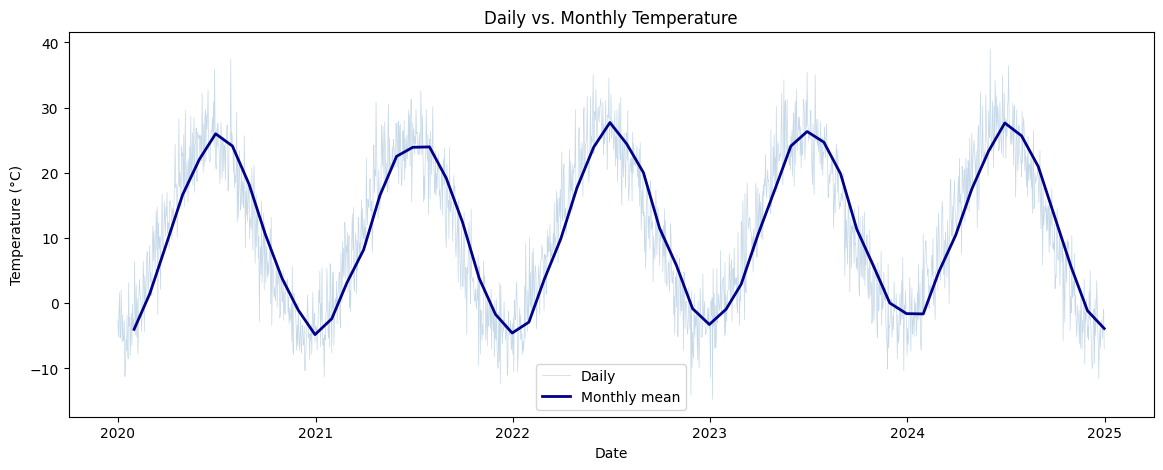

In [22]:
# Compare daily vs monthly temperature
fig, ax = plt.subplots(figsize=(14, 5))

# Daily data (light, thin line)
ax.plot(weather_ts.index, weather_ts['temperature_c'],
        color='steelblue', alpha=0.3, linewidth=0.5, label='Daily')

# Monthly means (bold line)
ax.plot(monthly.index, monthly.values,
        color='darkblue', linewidth=2, label='Monthly mean')

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Daily vs. Monthly Temperature')
ax.legend()

plt.show()

### 4.3 Annual Statistics

In [23]:
# Calculate annual statistics
annual = weather_ts['temperature_c'].resample('Y').agg(['mean', 'min', 'max'])
annual.index = annual.index.year  # Simplify index to just year
annual

/tmp/ipython-input-2055807749.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual = weather_ts['temperature_c'].resample('Y').agg(['mean', 'min', 'max'])


,mean,min,max
date,,,
2020,10.195107,-11.244089,37.424589
2021,10.454706,-12.296150,32.575130
2022,11.504714,-14.096428,35.079144
2023,11.726058,-14.722629,35.464131
2024,11.896621,-11.606965,38.958271


/tmp/ipython-input-2050825101.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_precip = weather_ts['precipitation_mm'].resample('Y').sum()


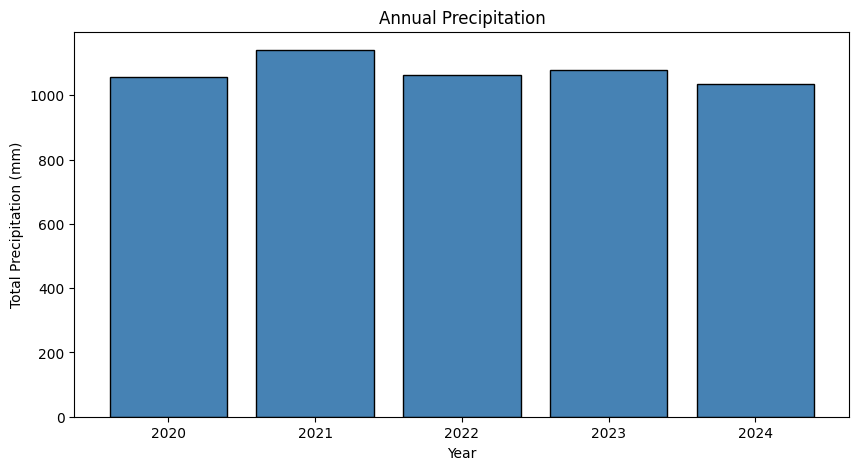

In [24]:
# Annual total precipitation
annual_precip = weather_ts['precipitation_mm'].resample('Y').sum()
annual_precip.index = annual_precip.index.year

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(annual_precip.index, annual_precip.values, color='steelblue', edgecolor='black')
ax.set_xlabel('Year')
ax.set_ylabel('Total Precipitation (mm)')
ax.set_title('Annual Precipitation')
plt.show()

---
## 5. Rolling Windows / Moving Averages

**Rolling windows** compute statistics over a sliding window of fixed size. This is useful for:
- Smoothing noisy data
- Identifying trends
- Calculating running statistics

### 5.1 Simple Moving Average

In [25]:
# Calculate 7-day moving average
weather_ts['temp_7day_ma'] = weather_ts['temperature_c'].rolling(window=7).mean()

# Calculate 30-day moving average
weather_ts['temp_30day_ma'] = weather_ts['temperature_c'].rolling(window=30).mean()

weather_ts[['temperature_c', 'temp_7day_ma', 'temp_30day_ma']].head(10)

,temperature_c,temp_7day_ma,temp_30day_ma
date,,,
2020-01-01,-2.680869,NaN,NaN
2020-01-02,-5.163469,NaN,NaN
2020-01-03,-1.958014,NaN,NaN
2020-01-04,1.609306,NaN,NaN
2020-01-05,-5.349179,NaN,NaN
2020-01-06,-5.274594,NaN,NaN
2020-01-07,2.057575,-2.394178,NaN
2020-01-08,-1.106540,-2.169273,NaN
2020-01-09,-5.966976,-2.284060,NaN


In [26]:
# Note: First (window-1) values are NaN
print(f"NaN values in 7-day MA: {weather_ts['temp_7day_ma'].isna().sum()}")
print(f"NaN values in 30-day MA: {weather_ts['temp_30day_ma'].isna().sum()}")

NaN values in 7-day MA: 6
NaN values in 30-day MA: 29


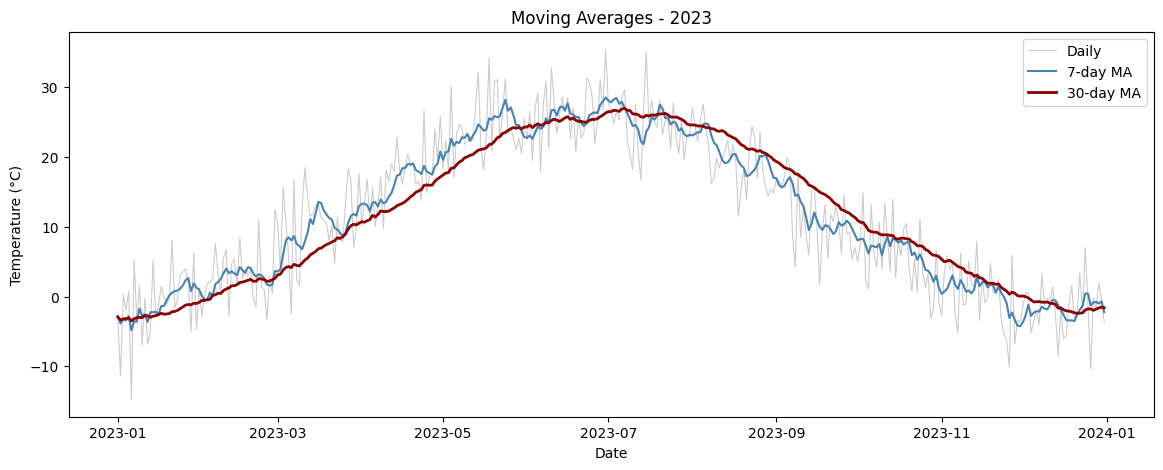

In [27]:
# Visualize smoothing effect
fig, ax = plt.subplots(figsize=(14, 5))

# Plot one year for clarity
year_data = weather_ts.loc['2023']

ax.plot(year_data.index, year_data['temperature_c'],
        alpha=0.4, linewidth=0.8, label='Daily', color='gray')
ax.plot(year_data.index, year_data['temp_7day_ma'],
        linewidth=1.5, label='7-day MA', color='steelblue')
ax.plot(year_data.index, year_data['temp_30day_ma'],
        linewidth=2, label='30-day MA', color='darkred')

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Moving Averages - 2023')
ax.legend()

plt.show()

### 5.2 Other Rolling Statistics

In [28]:
# Rolling standard deviation (variability)
weather_ts['temp_30day_std'] = weather_ts['temperature_c'].rolling(window=30).std()

# Rolling min and max
weather_ts['temp_30day_min'] = weather_ts['temperature_c'].rolling(window=30).min()
weather_ts['temp_30day_max'] = weather_ts['temperature_c'].rolling(window=30).max()

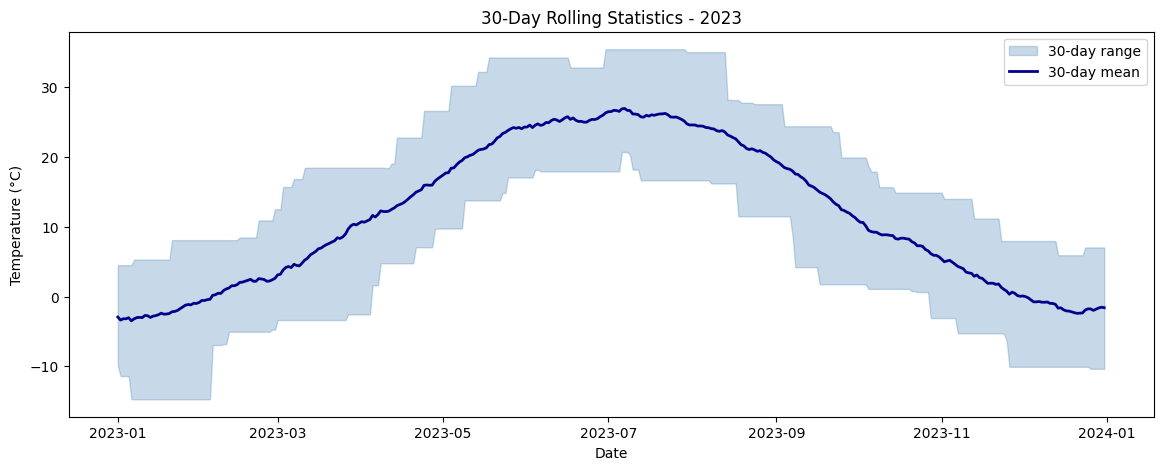

In [29]:
# Plot rolling range (min-max band)
fig, ax = plt.subplots(figsize=(14, 5))

year_data = weather_ts.loc['2023']

# Shaded region between rolling min and max
ax.fill_between(year_data.index,
                year_data['temp_30day_min'],
                year_data['temp_30day_max'],
                alpha=0.3, color='steelblue', label='30-day range')

# Rolling mean
ax.plot(year_data.index, year_data['temp_30day_ma'],
        linewidth=2, color='darkblue', label='30-day mean')

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')
ax.set_title('30-Day Rolling Statistics - 2023')
ax.legend()

plt.show()

### 5.3 Centered vs. Trailing Windows

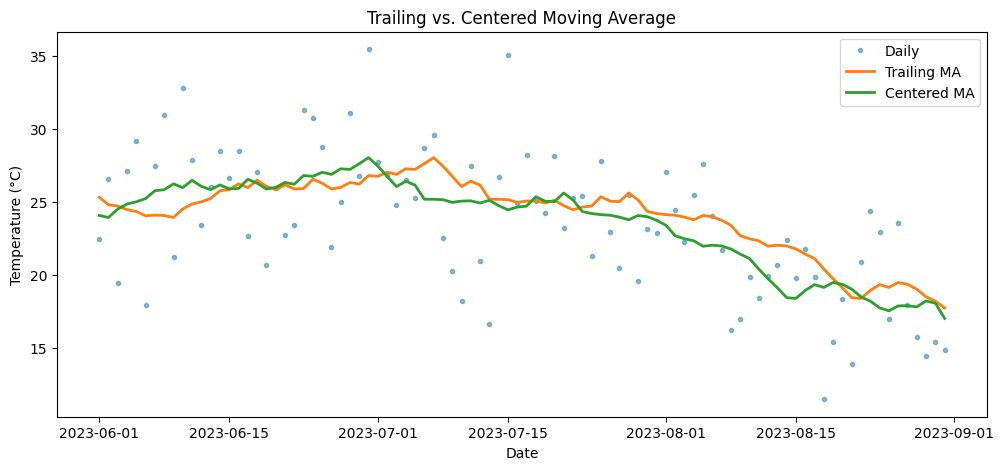

Note: Centered MA aligns better with peaks and valleys


In [30]:
# Default: trailing window (uses past values)
trailing = weather_ts['temperature_c'].rolling(window=15).mean()

# Centered window (uses past and future values)
centered = weather_ts['temperature_c'].rolling(window=15, center=True).mean()

# Compare
fig, ax = plt.subplots(figsize=(12, 5))

subset = weather_ts.loc['2023-06':'2023-08']
ax.plot(subset.index, subset['temperature_c'], 'o', markersize=3, alpha=0.5, label='Daily')
ax.plot(subset.index, trailing.loc['2023-06':'2023-08'], linewidth=2, label='Trailing MA')
ax.plot(subset.index, centered.loc['2023-06':'2023-08'], linewidth=2, label='Centered MA')

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Trailing vs. Centered Moving Average')
ax.legend()

plt.show()

print("Note: Centered MA aligns better with peaks and valleys")

---
## 6. Time Series Decomposition

Decomposition separates a time series into:
1. **Trend:** Long-term movement
2. **Seasonal:** Repeating patterns at fixed intervals
3. **Residual:** Random noise after removing trend and seasonality

### 6.1 Additive vs. Multiplicative

- **Additive:** Data = Trend + Seasonal + Residual (when seasonal amplitude is constant)
- **Multiplicative:** Data = Trend × Seasonal × Residual (when seasonal amplitude grows with trend)

In [31]:
# Perform decomposition
# Use period=365 for annual seasonality in daily data
decomposition = seasonal_decompose(
    weather_ts['temperature_c'],
    model='additive',
    period=365
)

# The result contains trend, seasonal, and residual components
print("Components:")
print(f"  - Trend: {type(decomposition.trend)}")
print(f"  - Seasonal: {type(decomposition.seasonal)}")
print(f"  - Residual: {type(decomposition.resid)}")

Components:
  - Trend: <class 'pandas.core.series.Series'>
  - Seasonal: <class 'pandas.core.series.Series'>
  - Residual: <class 'pandas.core.series.Series'>


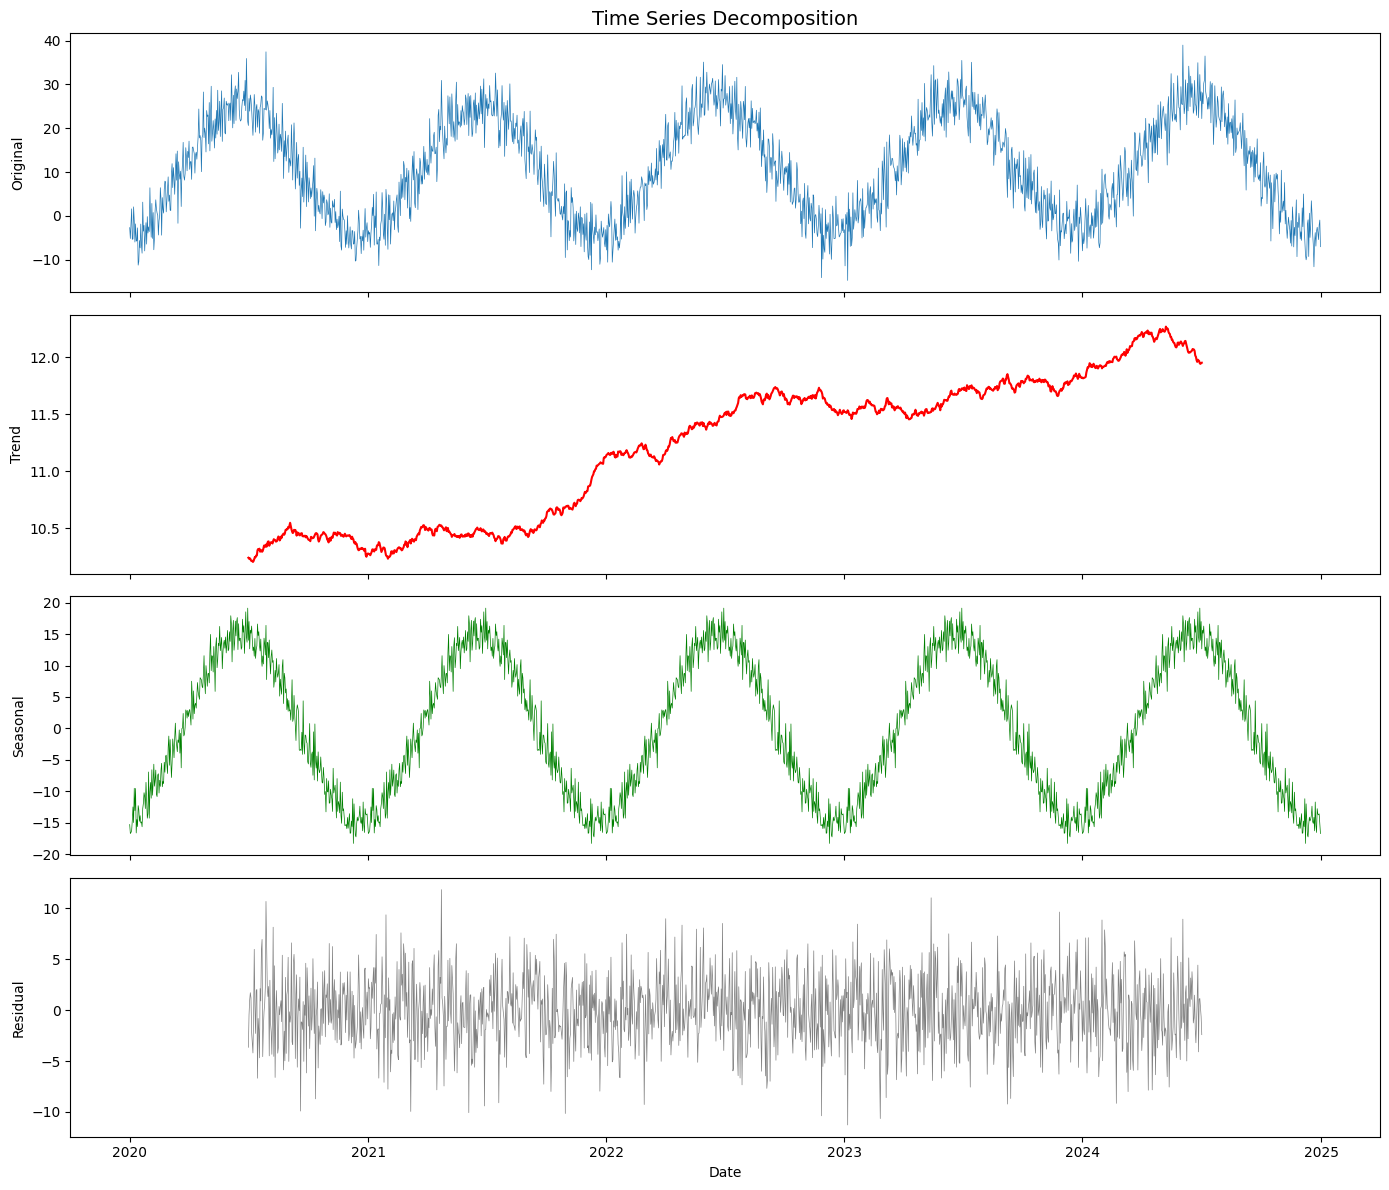

In [32]:
# Visualize decomposition
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# Original data
axes[0].plot(weather_ts.index, weather_ts['temperature_c'], linewidth=0.5)
axes[0].set_ylabel('Original')
axes[0].set_title('Time Series Decomposition', fontsize=14)

# Trend
axes[1].plot(weather_ts.index, decomposition.trend, color='red', linewidth=1.5)
axes[1].set_ylabel('Trend')

# Seasonal
axes[2].plot(weather_ts.index, decomposition.seasonal, color='green', linewidth=0.5)
axes[2].set_ylabel('Seasonal')

# Residual
axes[3].plot(weather_ts.index, decomposition.resid, color='gray', linewidth=0.5)
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Date')

plt.tight_layout()
plt.show()

### 6.2 Interpreting the Components

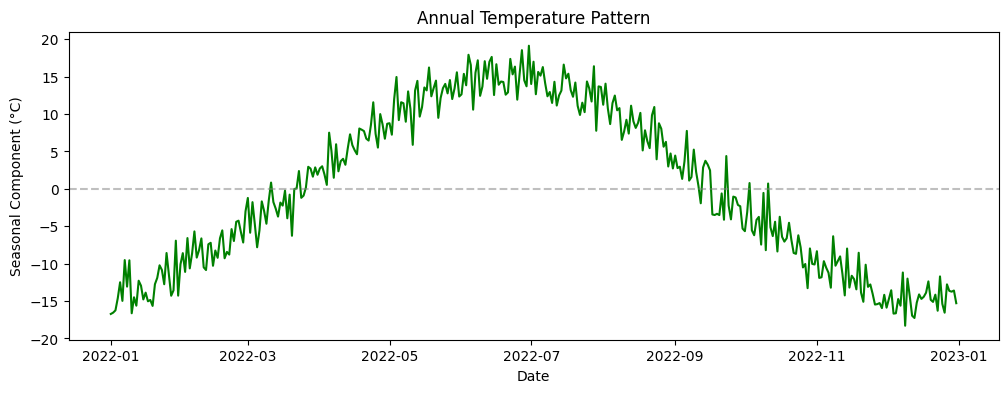

Seasonal amplitude: 37.4°C


In [33]:
# Extract one year of the seasonal component
seasonal_pattern = decomposition.seasonal.loc['2022']

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(seasonal_pattern.index, seasonal_pattern.values, color='green')
ax.set_xlabel('Date')
ax.set_ylabel('Seasonal Component (°C)')
ax.set_title('Annual Temperature Pattern')
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.show()

print(f"Seasonal amplitude: {seasonal_pattern.max() - seasonal_pattern.min():.1f}°C")

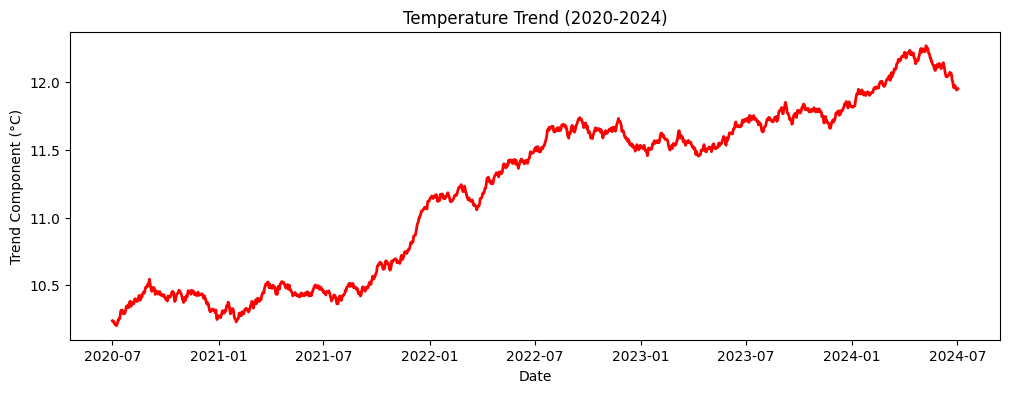

Trend change over period: 1.71°C


In [34]:
# Look at the trend
trend = decomposition.trend.dropna()

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(trend.index, trend.values, color='red', linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('Trend Component (°C)')
ax.set_title('Temperature Trend (2020-2024)')
plt.show()

# Calculate trend change
trend_change = trend.iloc[-1] - trend.iloc[0]
print(f"Trend change over period: {trend_change:.2f}°C")

### 6.3 Detrending and Deseasonalizing

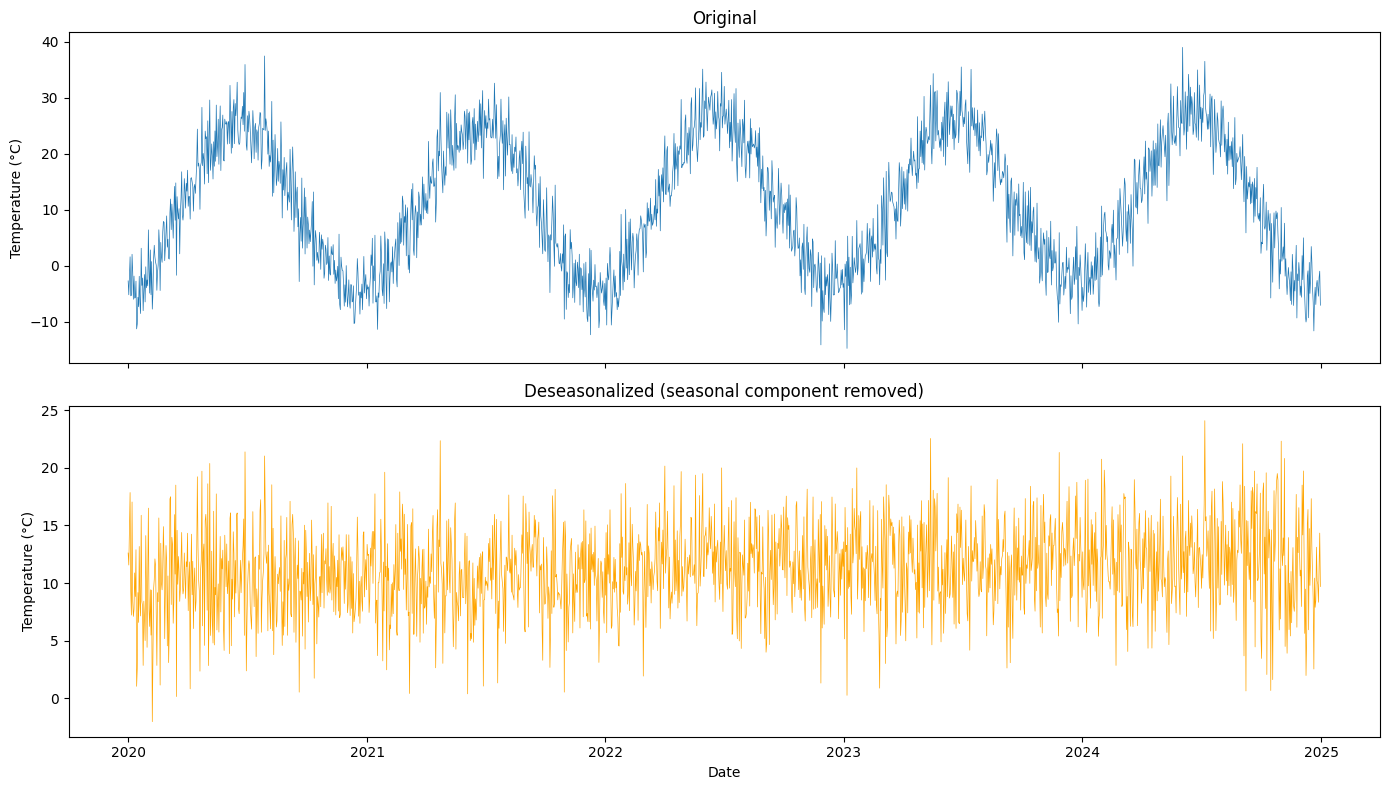

In [35]:
# Remove seasonality to see trend + residual
deseasonalized = weather_ts['temperature_c'] - decomposition.seasonal

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

axes[0].plot(weather_ts.index, weather_ts['temperature_c'], linewidth=0.5)
axes[0].set_ylabel('Temperature (°C)')
axes[0].set_title('Original')

axes[1].plot(weather_ts.index, deseasonalized, linewidth=0.5, color='orange')
axes[1].set_ylabel('Temperature (°C)')
axes[1].set_title('Deseasonalized (seasonal component removed)')
axes[1].set_xlabel('Date')

plt.tight_layout()
plt.show()

---
## 7. Introduction to Time Series Modeling

Time series modeling allows us to understand patterns and make forecasts.

### 7.1 Autocorrelation

**Autocorrelation** measures how a time series correlates with lagged versions of itself. This reveals:
- How past values influence future values
- Seasonal patterns (spikes at regular lags)

In [37]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

/tmp/ipython-input-3245984780.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_temp = weather_ts['temperature_c'].resample('M').mean()


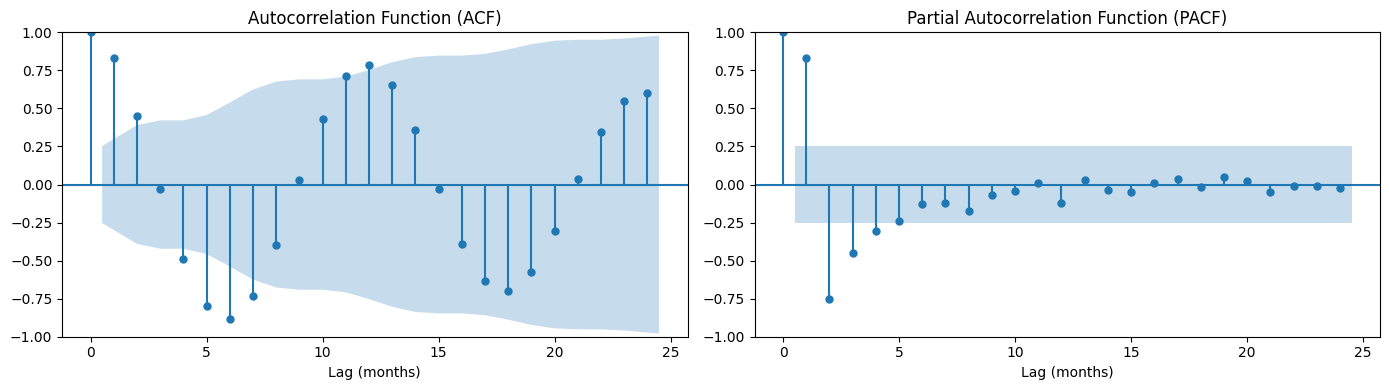

ACF shows correlation at lag 12 (annual cycle)
PACF shows direct relationship, removing intermediate effects


In [38]:
# Plot autocorrelation function (ACF)
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Use monthly data for clearer visualization
monthly_temp = weather_ts['temperature_c'].resample('M').mean()

plot_acf(monthly_temp.dropna(), lags=24, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')
axes[0].set_xlabel('Lag (months)')

plot_pacf(monthly_temp.dropna(), lags=24, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')
axes[1].set_xlabel('Lag (months)')

plt.tight_layout()
plt.show()

print("ACF shows correlation at lag 12 (annual cycle)")
print("PACF shows direct relationship, removing intermediate effects")

### 7.2 Stationarity

A **stationary** time series has constant statistical properties over time:
- Constant mean
- Constant variance
- No trend or seasonality

Most forecasting models require stationary data. We can test for stationarity using the **Augmented Dickey-Fuller (ADF) test**.

In [39]:
def check_stationarity(series, name):
    """Perform ADF test and report results."""
    result = adfuller(series.dropna())
    print(f"\n{name}:")
    print(f"  ADF Statistic: {result[0]:.4f}")
    print(f"  p-value: {result[1]:.4f}")
    if result[1] < 0.05:
        print("  → Stationary (reject null hypothesis)")
    else:
        print("  → Non-stationary (fail to reject null hypothesis)")

# Test original temperature data
check_stationarity(monthly_temp, "Original monthly temperature")

# Test deseasonalized data
check_stationarity(deseasonalized.resample('M').mean(), "Deseasonalized temperature")


Original monthly temperature:
  ADF Statistic: -0.9643
  p-value: 0.7661
  → Non-stationary (fail to reject null hypothesis)

Deseasonalized temperature:
  ADF Statistic: -0.8250
  p-value: 0.8117
  → Non-stationary (fail to reject null hypothesis)


/tmp/ipython-input-944833917.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  check_stationarity(deseasonalized.resample('M').mean(), "Deseasonalized temperature")


### 7.3 Differencing

**Differencing** removes trends by computing the change between consecutive observations.

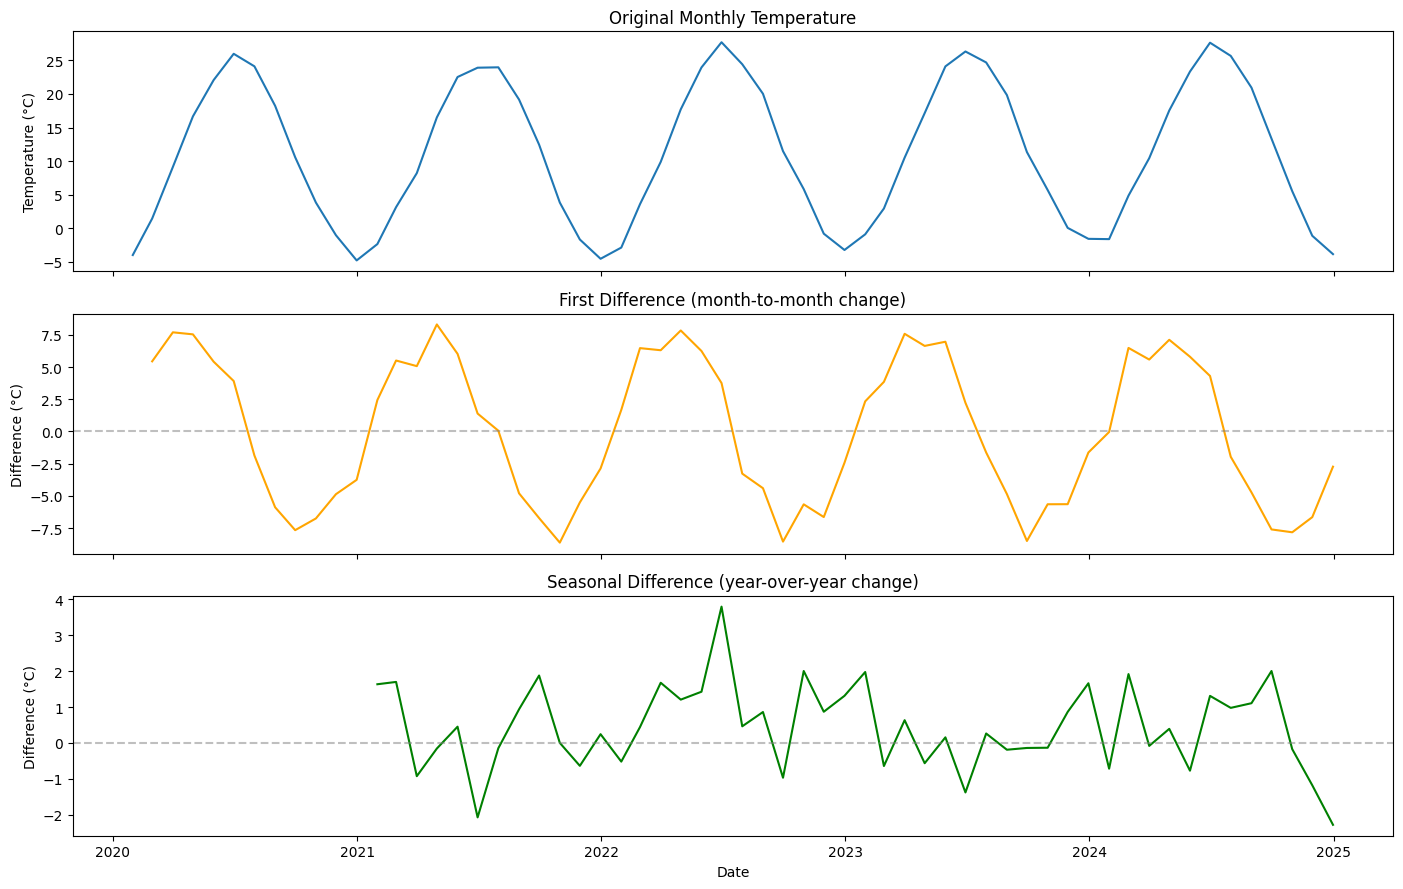

In [40]:
# First difference: y(t) - y(t-1)
temp_diff = monthly_temp.diff().dropna()

# Seasonal difference: y(t) - y(t-12) for monthly data
temp_seasonal_diff = monthly_temp.diff(12).dropna()

fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

axes[0].plot(monthly_temp.index, monthly_temp.values)
axes[0].set_ylabel('Temperature (°C)')
axes[0].set_title('Original Monthly Temperature')

axes[1].plot(temp_diff.index, temp_diff.values, color='orange')
axes[1].set_ylabel('Difference (°C)')
axes[1].set_title('First Difference (month-to-month change)')
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

axes[2].plot(temp_seasonal_diff.index, temp_seasonal_diff.values, color='green')
axes[2].set_ylabel('Difference (°C)')
axes[2].set_title('Seasonal Difference (year-over-year change)')
axes[2].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[2].set_xlabel('Date')

plt.tight_layout()
plt.show()

In [41]:
# Check if differencing achieved stationarity
check_stationarity(temp_diff, "First difference")
check_stationarity(temp_seasonal_diff, "Seasonal difference (lag=12)")


First difference:
  ADF Statistic: -5.1226
  p-value: 0.0000
  → Stationary (reject null hypothesis)

Seasonal difference (lag=12):
  ADF Statistic: -1.8537
  p-value: 0.3541
  → Non-stationary (fail to reject null hypothesis)


### 7.4 Simple Forecasting Methods

Before using complex models, try simple baselines:

| Method | Description |
|--------|-------------|
| Naive | Forecast = last observed value |
| Seasonal Naive | Forecast = value from same season last year |
| Moving Average | Forecast = average of last n observations |

In [42]:
# Split data into training and test sets
train = monthly_temp[:'2023']
test = monthly_temp['2024']

print(f"Training: {train.index[0].date()} to {train.index[-1].date()} ({len(train)} months)")
print(f"Test: {test.index[0].date()} to {test.index[-1].date()} ({len(test)} months)")

Training: 2020-01-31 to 2023-12-31 (48 months)
Test: 2024-01-31 to 2024-12-31 (12 months)


In [43]:
# Generate forecasts using simple methods

# 1. Naive: last value repeated
naive_forecast = pd.Series([train.iloc[-1]] * len(test), index=test.index)

# 2. Seasonal Naive: same month from last year
seasonal_naive_forecast = train.loc['2023'].values  # Use 2023 values for 2024
seasonal_naive_forecast = pd.Series(seasonal_naive_forecast, index=test.index)

# 3. Moving Average: average of last 12 months
ma_value = train.iloc[-12:].mean()
ma_forecast = pd.Series([ma_value] * len(test), index=test.index)

In [44]:
# Calculate forecast accuracy (RMSE)
def rmse(actual, predicted):
    return np.sqrt(np.mean((actual - predicted) ** 2))

print("Forecast Accuracy (RMSE):")
print(f"  Naive:          {rmse(test, naive_forecast):.2f}°C")
print(f"  Seasonal Naive: {rmse(test, seasonal_naive_forecast):.2f}°C")
print(f"  Moving Average: {rmse(test, ma_forecast):.2f}°C")

Forecast Accuracy (RMSE):
  Naive:          17.22°C
  Seasonal Naive: 1.27°C
  Moving Average: 10.72°C


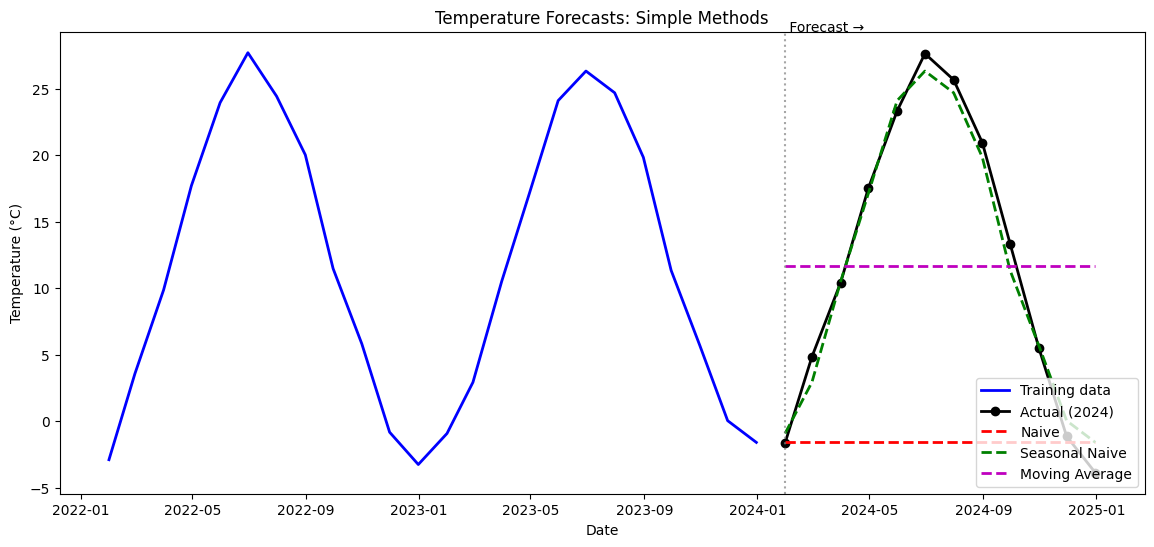


Seasonal Naive captures the annual pattern best for seasonal data!


In [45]:
# Visualize forecasts
fig, ax = plt.subplots(figsize=(14, 6))

# Training data (last 2 years)
ax.plot(train['2022':].index, train['2022':].values,
        'b-', linewidth=2, label='Training data')

# Actual test data
ax.plot(test.index, test.values,
        'ko-', linewidth=2, markersize=6, label='Actual (2024)')

# Forecasts
ax.plot(test.index, naive_forecast.values,
        'r--', linewidth=2, label='Naive')
ax.plot(test.index, seasonal_naive_forecast.values,
        'g--', linewidth=2, label='Seasonal Naive')
ax.plot(test.index, ma_forecast.values,
        'm--', linewidth=2, label='Moving Average')

ax.axvline(x=test.index[0], color='gray', linestyle=':', alpha=0.7)
ax.text(test.index[0], ax.get_ylim()[1], ' Forecast →', fontsize=10)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Temperature Forecasts: Simple Methods')
ax.legend(loc='lower right')

plt.show()

print("\nSeasonal Naive captures the annual pattern best for seasonal data!")

### 7.5 Exponential Smoothing (Brief Introduction)

**Exponential smoothing** gives more weight to recent observations. The **Holt-Winters** method handles both trend and seasonality.

In [46]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Holt-Winters model with additive seasonality
hw_model = ExponentialSmoothing(
    train,
    seasonal_periods=12,
    trend='add',
    seasonal='add'
).fit()

# Forecast
hw_forecast = hw_model.forecast(len(test))

print(f"Holt-Winters RMSE: {rmse(test, hw_forecast):.2f}°C")

Holt-Winters RMSE: 0.89°C


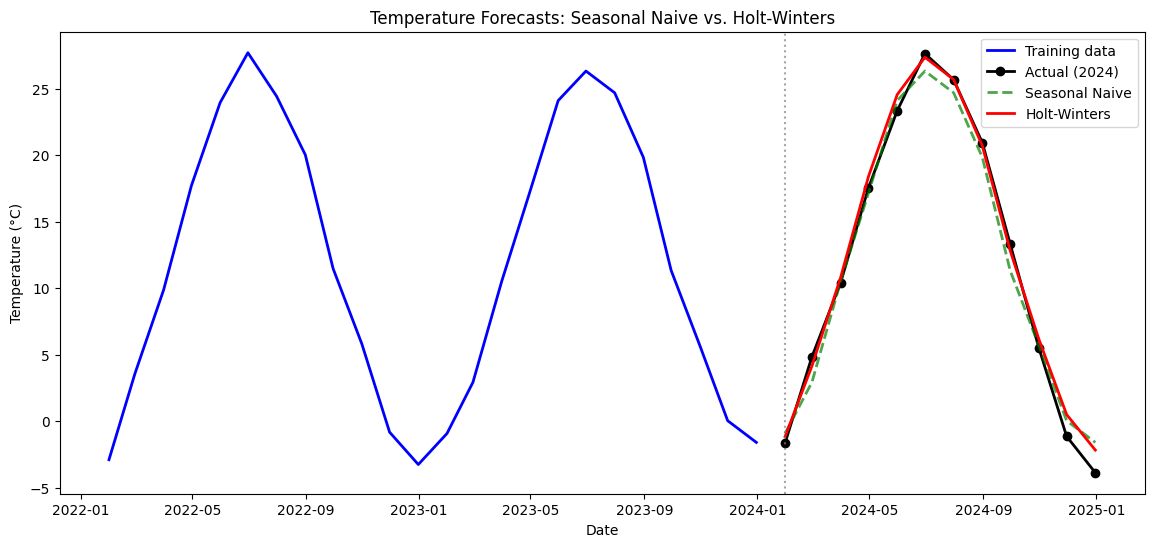

In [47]:
# Compare all methods
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(train['2022':].index, train['2022':].values,
        'b-', linewidth=2, label='Training data')
ax.plot(test.index, test.values,
        'ko-', linewidth=2, markersize=6, label='Actual (2024)')
ax.plot(test.index, seasonal_naive_forecast.values,
        'g--', linewidth=2, alpha=0.7, label='Seasonal Naive')
ax.plot(test.index, hw_forecast.values,
        'r-', linewidth=2, label='Holt-Winters')

ax.axvline(x=test.index[0], color='gray', linestyle=':', alpha=0.7)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Temperature Forecasts: Seasonal Naive vs. Holt-Winters')
ax.legend()

plt.show()

---
## 8. Quick Exercise (5 min)

Using the `weather_ts` DataFrame:

1. Calculate the **monthly total precipitation** for each month
2. Find which month (across all years) had the **highest total precipitation**
3. Calculate a **14-day rolling sum** of precipitation (useful for tracking cumulative rainfall)

In [ ]:
# Your code here



---
## Summary

| Task | Method |
|------|--------|
| Convert to datetime | `pd.to_datetime()` |
| Extract components | `.dt.year`, `.dt.month`, `.dt.dayofyear` |
| Set datetime index | `df.set_index('date')` |
| Select by date | `df.loc['2023-07']`, `df.loc['2023-06':'2023-08']` |
| Resample frequency | `df.resample('M').mean()`, `df.resample('Y').sum()` |
| Moving average | `df.rolling(window=7).mean()` |
| Decomposition | `seasonal_decompose(series, period=365)` |
| Autocorrelation | `plot_acf()`, `plot_pacf()` |
| Stationarity test | `adfuller()` |
| Differencing | `series.diff()`, `series.diff(12)` |
| Exponential smoothing | `ExponentialSmoothing().fit().forecast()` |

**Key Modeling Concepts:**
- Autocorrelation reveals how past values relate to future values
- Stationarity is required for many forecasting models
- Differencing can transform non-stationary data to stationary
- Always compare complex models to simple baselines (naive, seasonal naive)
- Holt-Winters handles trend and seasonality automatically

---
## Solution

In [ ]:
# Exercise Solution

# 1. Monthly total precipitation
monthly_precip = weather_ts['precipitation_mm'].resample('M').sum()
print("Monthly precipitation totals (first 12 months):")
print(monthly_precip.head(12))

# 2. Month with highest precipitation
max_precip_month = monthly_precip.idxmax()
max_precip_value = monthly_precip.max()
print(f"\nHighest precipitation: {max_precip_value:.1f} mm in {max_precip_month.strftime('%B %Y')}")

# 3. 14-day rolling sum
weather_ts['precip_14day_sum'] = weather_ts['precipitation_mm'].rolling(window=14).sum()
print(f"\n14-day rolling precipitation sum:")
print(weather_ts[['precipitation_mm', 'precip_14day_sum']].tail(10))